# Анализ стабильности распределения фичей

Входные данные 
- data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи
- data/interm/merge_cleaned.pkl из merge_and_clean.ipynb  

In [1]:
import pandas as pd

In [2]:
"""
Расчет фичей на каждый срез даты и расчет статистики занимает примерно 10 минут. Поэтому если одни раз рассчитался, 
то достаточно использовать уже сформированный и записанный в файл, для этого необходимо выставить переменную в False.
"""
need_to_calculate_statistics_mdm = True
need_to_psi_target = False
need_to_psi_mdm = False

need_to_remove_auxilary_files = True

In [3]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [4]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))
# target_features.head(2)

Размер считанных данных target_class with mdm features- (85798, 39)


In [5]:
name = pre + "data/interm/merge_cleaned.pkl"
df_mdm = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных фед ресурса mdm- {}".format(df_mdm.shape))

Размер считанных данных фед ресурса mdm- (1412787, 28)


In [6]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/feature_distribution_stability.xlsx"
writer = ExcelWriter(name)

## Заполним пустые значения в target-class features

In [7]:
for delta_col in target_features.columns:
    if (is_timedelta64_dtype(target_features[delta_col])):
       target_features[delta_col] = target_features[delta_col].dt.days
       target_features[delta_col] = target_features[delta_col].fillna(0)

# target_features.head(1)

#### Теперь формируем выборки для фрод и кред дефолта

In [8]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению

target_frod.print_param()

# target_frod.data.head(2)


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4708 из 63131 (7.46%)


In [9]:
target_frod.data["Метка дефолта"] = target_frod.data["Метка дефолта"].astype(int).astype(str)

## Рассчитываем статистику по всем фичам на target-data

In [10]:
data = target_frod.data
data['period'] = data['Дата принятия решения по сделке'].dt.strftime("%Y-%m")

range_period = pd.date_range(start="2021-01-31",end="2023-04-30", freq='MS')

statistics_target = pd.DataFrame()
for period in range_period:
    month = datetime.strftime(period, '%Y-%m')
    data_in_period = data[data['period']<=month]

    describe = data_in_period.describe().T
    describe = describe.join(data_in_period.quantile(0.95).to_frame().rename(columns={0.95:'95%'}))
    describe = describe.join(data_in_period.median(numeric_only=True).to_frame().rename(columns={0:'median'}))
   
    describe['period'] = month
    
    statistics_target = statistics_target.append(pd.DataFrame(describe))
    
statistics_target['time'] = pd.to_datetime(statistics_target['period'], format='%Y-%m')

# statistics_target['error_y_minus'] = np.where(statistics_target['mean']>statistics_target['std'], statistics_target['std'], statistics_target['mean'])
statistics_target = statistics_target.drop(index=['index', 'Метка фрод дефолта', 'Метка кред дефолта'])

statistics_target.sample(2)

,count,mean,std,min,25%,50%,75%,max,95%,median,period,time
reason_расторгнут,47129.0,0.078678,0.655116,0.0,0.0,0.0,0.0,30.0,0.0,0.0,2022-05,2022-05-01
contract_date_delta_last,37367.0,163.171649,270.769526,0.0,0.0,39.0,208.0,2827.0,773.7,39.0,2021-09,2021-09-01


#### выведем как изменялись статистические параметры обучающей выборки

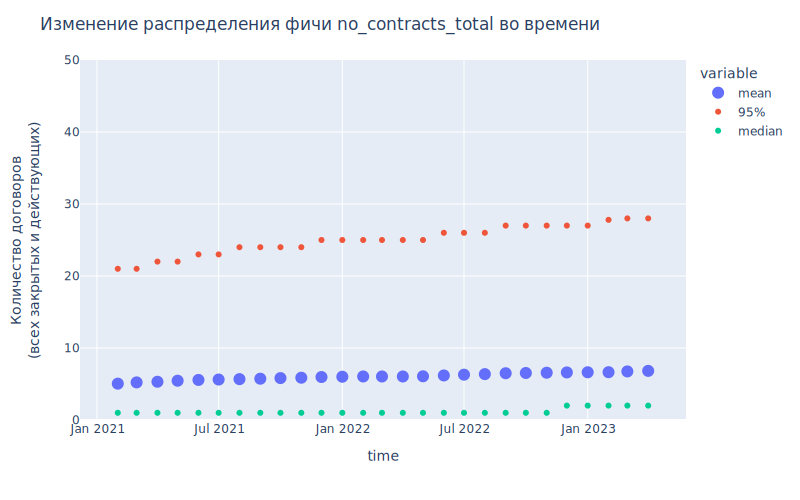

In [11]:
ranges = {'no_contracts_active': [0, 50], 
'no_transp_active' : [0, 50], 
'no_contracts_total':[0, 50], 
'no_transport_total' : [0, 50], 
'no_contracts_closed' : [0, 20], 
'reason_гибель/тотал' : [0, 0.1],
'reason_завершение' : [0, 10], 
'reason_замена/перенайм/переуступка' : [0, 0.06],
'reason_не указана' : [0, 10], 
'reason_определена цессия' : [0, 0.6], 
'reason_отмена' : [0, 3],
'reason_расторгнут' : [0, 2], 
'reason_страховой случай' : [0, 0.6],
'reason_страховой случай (гибель/тотал)' : [0, 0.04], 
'bad_reasons_closed' : [0, 2],
'good_reasons_closed' : [0, 10], 
'not_determined_reasons_closed' : [0, 14],
'mean_bad_reasons' : [0, 0.2], 
'mean_good_reasons' : [0, 1.4], 
'mean_not_determined_reasons' : [0, 1.4],
'no_creditors' : [0, 7], 
'duration_max' : [0, 1200], 
'duration_mean' : [0, 1000], 
'duration_min' : [0, 1000],
'contract_date_delta_first' : [0, 2000], 
'contract_date_delta_last' : [0, 1000],
'end_date_first' : [0, 1500], 
'end_date_last' : [0, 600]
}

list_of_figs_target = []

for feature in allFeaturesProperties.keys():
    feature_statistics = statistics_target.loc[feature].copy()
    title = 'Изменение распределения фичи {} во времени'.format(feature)
    fig = plot_statistics_over_time_target(feature_statistics, feature, title = title, y_range = ranges.get(feature))
    list_of_figs_target.append(fig)

list_of_figs_target[0].show('png' if need_svg else '')

## Расчет фичей данных для prediction (mdm) по месячно

для того, чтобы посмотреть на изменение во времени статистики и PSI по всем фичам массива MDM, на котором будет prediction, их нужно рассчитать на различные срезы времени, а не только на текущую дату, как в файле "data/interm/features_mdm.pkl"

In [12]:
def calc_features(cut_date):

    df_mdm_cut = df_mdm[df_mdm['new_kreditmessage_date']<=cut_date].copy()
    ## 1. посчитаем, количество договоров на дату публикации
    contacts_total = df_mdm_cut.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame()\
                        .reset_index().rename(columns={'origin_by_message':'no_contracts_total'})

    ## 2. посчитаем, количество договоров на дату публикации (только транспортных средств)
    transport_only = df_mdm_cut[(df_mdm_cut['new_leasingsubject_code'].notnull()) & (df_mdm_cut['new_leasingsubject_code'].str.startswith('0106'))]
    contacts_transp_total = transport_only.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame()\
                                            .reset_index().rename(columns={'origin_by_message':'no_transport_total'})

    ## 3. посчитаем количество активных договоров
    """для этого оставим последнюю запись по договам из mdm к нашим приложениям  и там посмотрим, завершен ли там договор или нет"""
    last = df_mdm_cut.sort_values(by=['new_lessee_inn', 'origin_by_message', 'new_kreditmessage_date']).drop_duplicates(subset=['new_lessee_inn', 'origin_by_message'], keep='last')
    """проставим stop_primary - предварительно вычисленная дата окончания, 
                        там где явно задано окончание, то  его указываем, там где не указано, то по договору лизинга
    процедура в init_mdm.ipynb """
    determine_stop_primary(last)
    
    """
    уберем те, уже закрытые на момент среза, будем считать только активные договоры
    """
    mask_closed = (last['stop_primary']<=cut_date)
    raw_active = last[~mask_closed].copy()
    active = raw_active.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame().reset_index().rename(columns={'origin_by_message':'no_contracts_active'})


    ### 4. Теперь считаем только активные по транспортным средствам
    transport_only_active = raw_active[(raw_active['new_leasingsubject_code'].notnull()) & (raw_active['new_leasingsubject_code'].str.startswith('0106'))]
    transp_active = transport_only_active.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame()\
                                .reset_index().rename(columns={'origin_by_message':'no_transp_active'})

    ### 5. Расчет фичей:
    """
    - no_contracts_closed -  количество завершенных договоров
    - количества причин завершения у нашего лизингополучателя:

    уберем все активные на момент принятия решения, будем считать только закрытые договоры

    """
    mask_closed = (last['stop_primary']<=cut_date)

    raw_closed = last[mask_closed].copy()

    mask = (raw_closed['reason']=='')
    raw_closed.loc[mask, 'reason'] = 'не указана'
    closed = raw_closed.groupby('new_lessee_inn')['origin_by_message'].aggregate('nunique').to_frame().reset_index().rename(columns={'origin_by_message':'no_contracts_closed'})

    dummies = pd.get_dummies(raw_closed["reason"], prefix="reason")
    col_reasons = dummies.columns.to_list()
    raw_closed_reasons = raw_closed.join(dummies)
    closed_reasons = raw_closed_reasons.groupby('new_lessee_inn')[col_reasons].aggregate('sum').reset_index()

    """
    bad_reasons_closed - плохое завершение предыдущих договоров  
    good_reasons_closed - хорошее завершение предыдущих договоров  
    not_determined_reasons_closed - неопределенное завершение предыдущих договоров  
    """

    bad = ['reason_гибель/тотал', 'reason_расторгнут', 'reason_страховой случай (гибель/тотал)']
    good = ['reason_завершение']
    not_determined = ['reason_замена/перенайм/переуступка', 'reason_не указана', 'reason_определена цессия', 'reason_отмена', 'reason_страховой случай']

    closed_reasons['bad_reasons_closed'] = closed_reasons[bad].sum(axis=1)
    closed_reasons['good_reasons_closed'] = closed_reasons[good].sum(axis=1)
    closed_reasons['not_determined_reasons_closed'] = closed_reasons[not_determined].sum(axis=1)

    # небольшая проверка, что все закрытые договоры были разнесены на 3 подгруппы
    closed_w_reasons = closed_reasons.copy()
    closed_w_reasons = closed_w_reasons.fillna(0)

    closed_w_reasons['closed'] = closed_w_reasons[['bad_reasons_closed',	'good_reasons_closed',	'not_determined_reasons_closed']].sum(axis=1)
    closed_w_reasons = pd.merge(closed, closed_w_reasons , how = 'outer', on='new_lessee_inn')
    Check_length(len(closed_w_reasons), len(closed))

    tmp = check_fields(closed_w_reasons,'closed', 'no_contracts_closed' )

    closed_w_reasons.drop(columns='closed', inplace=True)
    mask = (closed_w_reasons['no_contracts_closed']==0)

    closed_w_reasons.loc[mask, 'mean_bad_reasons'] = 0
    closed_w_reasons.loc[~mask, 'mean_bad_reasons'] = closed_w_reasons.loc[~mask, 'bad_reasons_closed']/closed_w_reasons.loc[~mask, 'no_contracts_closed']

    closed_w_reasons.loc[mask, 'mean_good_reasons'] = 0
    closed_w_reasons.loc[~mask, 'mean_good_reasons'] = closed_w_reasons.loc[~mask, 'good_reasons_closed']/closed_w_reasons.loc[~mask, 'no_contracts_closed']

    closed_w_reasons.loc[mask, 'mean_not_determined_reasons'] = 0
    closed_w_reasons.loc[~mask, 'mean_not_determined_reasons'] = closed_w_reasons.loc[~mask, 'not_determined_reasons_closed']/closed_w_reasons.loc[~mask, 'no_contracts_closed']

    ### 6. Длительность закрытых договоров
    raw_closed['Длительность'] = raw_closed['stop_primary'] - raw_closed['new_leasingcontract_date']
    mask = (raw_closed['Длительность']<pd.Timedelta(days=0))
    raw_closed.loc[mask, 'Длительность'] = pd.Timedelta(days=0)

    duration = pd.pivot_table(raw_closed, index='new_lessee_inn',  values='Длительность',  aggfunc={'min', 'mean', 'max'})\
        .rename(columns={'max':'duration_max', 'mean':'duration_mean', 'min':'duration_min'})

    for col in duration.columns:
        if col == 'new_lessee_inn':
            continue
        duration[col] = duration[col].round('D')
    duration.reset_index(inplace=True)

    ### 7. Разница между текущей расчетной датой и датой первого и последнего договора в фед ресурсе
    """
    у некоторых договоров дата договора стоит неправильная, больше текущей даты, 
    у некоторых договоров дата договора не проставлена 
    у таких договоров разница не имеет смысла, она будут исключены их расчета
    """
    last['contract_date_delta'] = cut_date - last['new_leasingcontract_date']
    tmp = last[last['contract_date_delta']>=pd.Timedelta(days=0)]
    contract_timedelta = pd.pivot_table(tmp, index='new_lessee_inn',  values='contract_date_delta', aggfunc={'min', 'max'})\
        .rename(columns={'max':'contract_date_delta_first', 'min':'contract_date_delta_last'}).reset_index()

    contract_timedelta['contract_date_delta_last'] = contract_timedelta['contract_date_delta_last'].round('D')
    contract_timedelta['contract_date_delta_first'] = contract_timedelta['contract_date_delta_first'].round('D')

    ### 8. Разница между текущей датой и датой закрытия договора в фед ресурсе
    raw_closed['contract_date_delta'] = cut_date - raw_closed['stop_primary']

    end_date_timedelta = pd.pivot_table(raw_closed, index='new_lessee_inn',  values='contract_date_delta', aggfunc={'min', 'max'})\
        .rename(columns={'max':'end_date_first', 'min':'end_date_last'}).reset_index()

    end_date_timedelta['end_date_last'] = end_date_timedelta['end_date_last'].round('D')
    end_date_timedelta['end_date_first'] = end_date_timedelta['end_date_first'].round('D')

    ### 9. Количество различных лизингодателей
    last['new_creditor_inn'] = last['new_creditor_inn'].fillna("")
    creditors = last.groupby('new_lessee_inn')['new_creditor_inn'].aggregate('nunique').to_frame().reset_index().rename(columns={'new_creditor_inn':'no_creditors'})

    # Соединяем все фичи в один Dataframe и записываем в pkl файл
    # contacts_total содержит полный перечень new_lessee_inn, поэтому берется за основу

    tmp = pd.merge(contacts_total, contacts_transp_total , how = 'left', on='new_lessee_inn')

    tmp = pd.merge(tmp, active, how = 'left', on='new_lessee_inn')
    tmp = pd.merge(tmp, transp_active , how = 'left', on='new_lessee_inn')

    tmp = pd.merge(tmp, closed_w_reasons , how = 'left', on='new_lessee_inn')
    tmp = pd.merge(tmp, creditors , how = 'left', on='new_lessee_inn')

    tmp = pd.merge(tmp, duration , how = 'left', on='new_lessee_inn')
    tmp = pd.merge(tmp, contract_timedelta , how = 'left', on='new_lessee_inn')
    features = pd.merge(tmp, end_date_timedelta , how = 'left', on='new_lessee_inn')


    Check_length(len(contacts_total), len(features))

    list_of_features = ['no_contracts_active', 'no_transp_active', 'no_contracts_total', 
                        'no_transport_total', 'no_contracts_closed', 'bad_reasons_closed', 
                        'good_reasons_closed', 'not_determined_reasons_closed', 
                        'mean_bad_reasons','mean_good_reasons', 'mean_not_determined_reasons', 
                        'no_creditors']

    for col in list_of_features:
        features[col] = features[col].fillna(0)

    for col in col_reasons:
        features[col] = features[col].fillna(0)

    return features



In [13]:
""" если уже рассчитывали. то можно взять из файла"""
# need_to_calculate_statistics_mdm = False

feature_in_period = pd.DataFrame()

if need_to_calculate_statistics_mdm:
    end = df_mdm['new_kreditmessage_date'].max()
    range_period = pd.date_range(start="2021-01-01",end=end, freq='MS')

    statistics_mdm = pd.DataFrame()
    for period in tqdm(range_period, colour= 'green'):

        month = datetime.strftime(period, '%Y-%m')
        data_in_period = calc_features(period)

        for delta_col in data_in_period.columns:
            if (is_timedelta64_dtype(data_in_period[delta_col])):
                data_in_period[delta_col] = data_in_period[delta_col].dt.days
                data_in_period[delta_col] = data_in_period[delta_col].fillna(0)

        describe = data_in_period.describe().T
        describe = describe.join(data_in_period.quantile(0.95).to_frame().rename(columns={0.95:'95%'}))
        describe = describe.join(data_in_period.median(numeric_only=True).to_frame().rename(columns={0:'median'}))
        
        describe['period'] = month
               
        statistics_mdm = statistics_mdm.append(pd.DataFrame(describe))
        
        data_in_period['period'] = month
        feature_in_period = feature_in_period.append(data_in_period)

        
    statistics_mdm['time'] = pd.to_datetime(statistics_mdm['period'], format='%Y-%m')
    feature_in_period['time'] = pd.to_datetime(feature_in_period['period'], format='%Y-%m')
    

    statistics_mdm.to_pickle(pre+"data/interm/statistics_mdm.pkl", compression={'method':'zip'})
    feature_in_period.to_pickle(pre+"data/interm/feature_in_period.pkl", compression={'method':'zip'})
    
else:
    name = pre + "data/interm/statistics_mdm.pkl"
    statistics_mdm = pd.read_pickle(name, compression={'method':'zip'})

    print("Размер считанных данных статистики MDM statistics_mdm- {}".format(statistics_mdm.shape))

    name = pre + "data/interm/feature_in_period.pkl"
    feature_in_period = pd.read_pickle(name, compression={'method':'zip'})

    print("Размер считанных данных фичей во времени MDM - {}".format(feature_in_period.shape))

statistics_mdm.sample(2)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [16:42<00:00, 31.32s/it]


,count,mean,std,min,25%,50%,75%,max,95%,median,period,time
end_date_first,227137.0,477.772344,675.277822,0.0,0.0,246.0,797.0,98827.0,1676.0,246.0,2023-08,2023-08-01
contract_date_delta_first,202434.0,905.648295,551.837344,0.0,455.0,827.0,1296.0,20085.0,1925.0,827.0,2022-07,2022-07-01


100%|██████████| 28/28 [00:06<00:00,  4.32it/s]


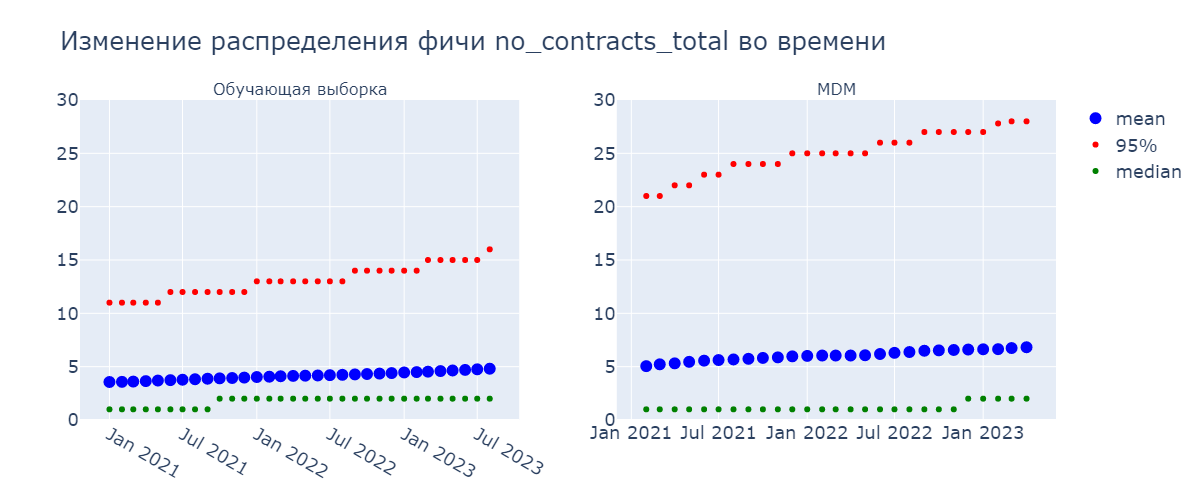

In [14]:
config = dict({'modeBarButtonsToAdd': ['hovercompare']})

ranges = {'no_contracts_active': [0, 30], 
'no_transp_active' : [0, 30], 
'no_contracts_total':[0, 30], 
'no_transport_total' : [0, 30], 
'no_contracts_closed' : [0, 20], 
'reason_гибель/тотал' : [0, 0.06],
'reason_завершение' : [0, 8], 
'reason_замена/перенайм/переуступка' : [0, 0.2],
'reason_не указана' : [0, 20], 
'reason_определена цессия' : [0, 1.5], 
'reason_отмена' : [0, 2],
'reason_расторгнут' : [0, 2], 
'reason_страховой случай' : [0, 1],
'reason_страховой случай (гибель/тотал)' : [0, 0.02], 
'bad_reasons_closed' : [0, 2],
'good_reasons_closed' : [0, 10], 
'not_determined_reasons_closed' : [0, 14],
'mean_bad_reasons' : [0, 0.2], 
'mean_good_reasons' : [0, 1.4], 
'mean_not_determined_reasons' : [0, 1.4],
'no_creditors' : [0, 4], 
'duration_max' : [0, 1200], 
'duration_mean' : [0, 1200], 
'duration_min' : [0, 1200],
'contract_date_delta_first' : [0, 2500], 
'contract_date_delta_last' : [0, 2500],
'end_date_first' : [0, 2000], 
'end_date_last' : [0, 2000]
}

list_of_figs = []

for feature, featureProperty in tqdm(allFeaturesProperties.items()):
    title = 'Изменение распределения фичи {} во времени'.format(feature)

    df_stat_mdm = statistics_mdm.loc[feature].copy()
    df_stat_target = statistics_target.loc[feature].copy()

    fig = plot_feature_statistics_over_time_mdm_target(df_stat_mdm, df_stat_target, title = title, y_range = ranges.get(feature))

    list_of_figs.append(fig)

combine_plotly_figs_to_html(list_of_figs, pre+'data/html/statistics_stability.html')
list_of_figs[0].show('png' if need_svg else '')

# Расчет PSI

### Разделение данных на базовую и тестовую выборки по времен. Расчет PSI у обучающей выборки

In [15]:
""" При разбиении была попытка уравнять в каждом бине процентное соотношение значений, где это возможно
из-за того, что у многих значений, например нулевых, больше чем 0.05, 
то такие группы будут содержать большее количество процентов значений"""

def get_num_groups_wanted_target(feature):
    if feature in [ 'reason_замена/перенайм/переуступка', 'reason_страховой случай (гибель/тотал)']: 
        num_groups_wanted = 100000 # 0.001%
    elif feature in ['reason_гибель/тотал'] :
        num_groups_wanted = 20000 # 0.005%
    elif feature in ['reason_определена цессия',  ]: 
        num_groups_wanted = 5000 # 0.02%
    elif feature in ['reason_страховой случай', ]: 
        num_groups_wanted = 1000 # 0.1%
    elif feature in ['reason_расторгнут', ]: 
        num_groups_wanted = 500 # 0.2%
    elif feature in ['bad_reasons_closed', ] :
        num_groups_wanted = 200 # 0.5%
    elif feature in [ 'reason_отмена', 'mean_bad_reasons',] :
        num_groups_wanted = 100 # 1%
    elif feature in [ 'mean_good_reasons'	]: 
        num_groups_wanted = 30 # 2%
    else: 
        num_groups_wanted = 20 # 5%
    return num_groups_wanted

target_data = target_frod.data
"""Если уже psi рассчитывались, то можно взять из файла"""
# need_to_psi_target = False

if need_to_psi_target:
    bins_target = pd.DataFrame()
    for feature, featureProperty in tqdm(allFeaturesProperties.items()):

        mask = (target_data['period']>="2021-01-01") & (target_data['period']<="2021-12-31")
        base_data = target_data[mask].copy()

        if featureProperty['for_closed']:
            base_data = base_data[base_data['no_contracts_closed']>0]
        elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
            base_data = base_data[base_data[feature]>0]

        num_groups_wanted = get_num_groups_wanted_target(feature)

        bins = base_data[feature].quantile(np.array(range(0, num_groups_wanted+1))/num_groups_wanted).unique()
        
        if featureProperty['type'] != 'float': 
            bins = list(set(bins.astype(int)))

        bins.sort()
        n_bins = len(bins)

        binned1 = np.digitize(base_data[feature], bins)

        prop = np.array([round(sum(binned1 == i) / len(binned1)*100,2) for i in range(1, n_bins)])

        bins_target = bins_target.append(pd.DataFrame([{'feature':feature, 'n_bins':n_bins, 'bins':np.array(bins).round(2), 'Проценты в бине':prop}]))
    
    bins_target.to_excel(writer, sheet_name='bins_target')
    display_side_by_side(bins_target)

In [16]:
""" 
Разделение обучающих данных на базовую и тестовую выборки по времени
В качестве базовой будут браться все за 2021 год "2021-01-01"-"2021-12-31"
В качестве тестовой помесячные данные от "2022-01-01" до "2023-04-01" 
"""

"""Если уже psi рассчитывались, то можно взять из файла"""
# need_to_psi_target = False

if need_to_psi_target:

    target_data = target_frod.data.copy()
    target_data['period'] = target_data['Дата принятия решения по сделке'].dt.strftime("%Y-%m")

    psi_target = pd.DataFrame()

    range_period = pd.date_range(start="2022-01-01",end="2023-04-01", freq='MS')

    for feature, featureProperty in tqdm(allFeaturesProperties.items()):

        mask = (target_data['period']>="2021-01-01") & (target_data['period']<="2021-12-31")
        base_data = target_data[mask].copy()

        if featureProperty['for_closed']:
            base_data = base_data[base_data['no_contracts_closed']>0]
        elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
            base_data = base_data[base_data[feature]>0]

        num_groups_wanted = get_num_groups_wanted_target(feature)

        bins = base_data[feature].quantile(np.array(range(0, num_groups_wanted+1))/num_groups_wanted).unique()
        if featureProperty['type'] !='float': 
            bins = list(set(bins.astype(int)))

        bins.sort()
        n_bins = len(bins)
        
        for period in range_period:
            month = datetime.strftime(period, '%Y-%m')
            data_test = target_data[target_data['period']==month].copy()
                
            if featureProperty['for_closed']:
                data_test = data_test[data_test['no_contracts_closed']>0]
            elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
                data_test = data_test[data_test[feature]>0]

            binned1 = np.digitize(base_data[feature], bins)
            binned2 = np.digitize(data_test[feature], bins)

            # Вычисление долей объектов в каждом бине
            elipson=0.0001
            prop1 = np.array([sum(binned1 == i) / len(binned1) for i in range(1, n_bins)]) + elipson
            prop2 = np.array([sum(binned2 == i) / len(binned2) for i in range(1, n_bins)]) + elipson

            # Вычисление PSI
            psi_value = np.sum((prop1 - prop2) * np.log(prop1 / prop2))
            psi_target = psi_target.append(pd.DataFrame([{'psi_value':psi_value, 'feature':feature, 'month':month}]))

    psi_target.to_pickle(pre+"data/interm/psi_target.pkl", compression={'method':'zip'})
else:
    name = pre + "data/interm/psi_target.pkl"
    psi_target = pd.read_pickle(name, compression={'method':'zip'})

    print("Размер считанных данных psi_target- {}".format(psi_target.shape))
   
psi_target.sample(2)  

Размер считанных данных psi_target- (448, 3)


,psi_value,feature,month
0,0.028708,not_determined_reasons_closed,2022-08
0,0.000628,reason_замена/перенайм/переуступка,2022-05


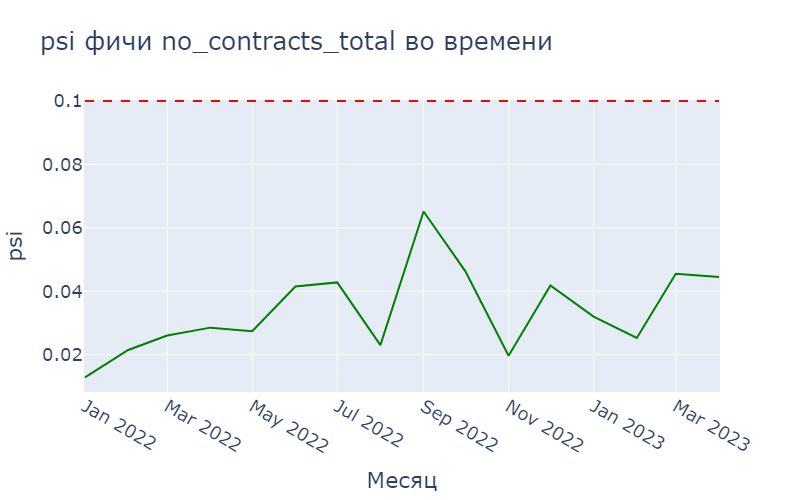

In [17]:
list_of_figs_mdm = []

for feature, featureProperty in allFeaturesProperties.items():
    feature_name = featureProperty['short_name']

    title = 'psi фичи {} во времени'.format(feature)
    mask = (psi_target['feature']==feature)
    fig = psi_plot(psi_target[mask], title = title)
    list_of_figs_mdm.append(fig)

combine_plotly_figs_to_html(list_of_figs_mdm, pre+'data/html/psi_target.html')
list_of_figs_mdm[0].show('png' if need_svg else '')

### Расчет PSI фичей MDM

In [18]:
""" 
Разделение обучающих данных на базовую и тестовую выборки MDM по времени
В качестве массива для определения бинов будут браться все данные на последний месяц
"""

"""Если уже psi рассчитывались, то можно взять из файла"""
# need_to_psi_target = False


def get_num_groups_wanted_mdm(feature):
    if feature in [ 'reason_страховой случай (гибель/тотал)']: 
        num_groups_wanted = 100000 # 0.001%
    elif feature in ['reason_гибель/тотал', 'reason_замена/перенайм/переуступка',] :
        num_groups_wanted = 20000 # 0.005%
    elif feature in ['reason_определена цессия',]: 
        num_groups_wanted = 5000 # 0.02%
    elif feature in [ 'bad_reasons_closed',]: 
        num_groups_wanted = 1000 # 0.1%
    elif feature in ['reason_расторгнут',  'reason_страховой случай',] :
        num_groups_wanted = 200 # 0.5%
    elif feature in [ 'reason_отмена', 'mean_bad_reasons', 'mean_good_reasons',] :
        num_groups_wanted = 100 # 1%
    elif feature in [ 'no_transp_active', 
                    'good_reasons_closed',  'reason_завершение', 'no_creditors']: 
        num_groups_wanted = 30 # 2%
    elif feature in [ 'contract_date_delta_first', 
                    'contract_date_delta_last', 'end_date_last', 'end_date_first']: 
        num_groups_wanted = 10 # 10%
    else: 
        num_groups_wanted = 20 # 5%

    return num_groups_wanted

"""Если уже psi рассчитывались, то можно взять из файла"""
# need_to_psi_mdm = False

# в качестве базовой берем последние фичи на последнюю дату
mdm_data = feature_in_period[feature_in_period['period'] == feature_in_period['period'].max()]

bins_mdm = pd.DataFrame()

if need_to_psi_mdm:
    for feature, featureProperty in tqdm(allFeaturesProperties.items()):

        base_data = mdm_data.copy()
        if featureProperty['for_closed']:
            base_data = base_data[base_data['no_contracts_closed']>0]
        elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
            base_data = base_data[base_data[feature]>0]

        num_groups_wanted = get_num_groups_wanted_mdm(feature)

        bins = base_data[feature].quantile(np.array(range(0, num_groups_wanted+1))/num_groups_wanted).unique()
        if featureProperty['type'] != 'float': 
            bins = list(set(bins.astype(int)))

        bins.sort()
        n_bins = len(bins)

        binned1 = np.digitize(base_data[feature], bins)

        prop = np.array([round(sum(binned1 == i) / len(binned1)*100,2) for i in range(1, n_bins)])

        bins_mdm = bins_mdm.append(pd.DataFrame([{'feature':feature, 'n_bins':n_bins, 'bins':np.array(bins).round(2), 'Проценты в бине':prop}]))
        
        # if feature == 'no_contracts_total':
        #     break

    bins_mdm.to_excel(writer, sheet_name='bins_mdm')
    display_side_by_side(bins_mdm)

In [19]:
""" 
В первом случае в качестве базового распределения (Expected) base_data использовались фичи, сформированные по данным, 
опубликованным до 2021-12 включительно, то есть с условием new_kreditmessage_date <=2021-12-31.
В качестве Actual(data_test) использовались фичи, сформированные по данным, опубликованным с 2022-01-01 по 2023-04-01 помесячно. 

Во втором случае в качестве базового распределения (Expected) base_data использовались фичи, сформированные по данным, 
опубликованным до 2022-04-30 включительно, то есть с условием new_kreditmessage_date <=2022-04-30.
В качестве Actual (data_test) использовались фичи, сформированные по данным, опубликованным с 2022-05-01 по 2023-04-01 помесячно. 
Использование второго расчета позволяет определить стабильность фичей на горизонте 12 месяцев. 

"""
# need_to_psi_mdm = True
if need_to_psi_mdm:

    mdm_data = feature_in_period.copy()
    psi_mdm = pd.DataFrame()

    # сделаем 2 базовых периода
    for base_period in ["2021-12", "2022-04"]:
        
        start = datetime.strptime(base_period, '%Y-%m') + pd.DateOffset(months=1)
        range_period = pd.date_range(start=start, end="2023-04-01", freq='MS')
        
         
        for feature, featureProperty in tqdm(allFeaturesProperties.items(), desc=base_period) :
                
            bins = bins_mdm.loc[bins_mdm['feature']==feature, 'bins'][0]
            n_bins = len(bins)

            mask = (mdm_data['period']==base_period)
            base_data = mdm_data[mask].copy()
            
            if featureProperty['for_closed']:
                base_data = base_data[base_data['no_contracts_closed']>0]
            elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
                base_data = base_data[base_data[feature]>0]

            for period in range_period:
                month = datetime.strftime(period, '%Y-%m')
                data_test = mdm_data[mdm_data['period']==month].copy()

                if featureProperty['for_closed']:
                    data_test = data_test[data_test['no_contracts_closed']>0]
                elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
                    data_test = data_test[data_test[feature]>0]

                binned1 = np.digitize(base_data[feature], bins)
                binned2 = np.digitize(data_test[feature], bins)

                # Вычисление долей объектов в каждом бине
                elipson=0.0001
                prop1 = np.array([sum(binned1 == i) / len(binned1) for i in range(1, n_bins)]) + elipson
                prop2 = np.array([sum(binned2 == i) / len(binned2) for i in range(1, n_bins)]) + elipson

                # Вычисление PSI
                psi_value = np.sum((prop1 - prop2) * np.log(prop1 / prop2))
                psi_mdm = psi_mdm.append(pd.DataFrame([{'base_period':base_period, 'psi_value':psi_value, 'feature':feature, 'month':month}]))
                
    psi_mdm.to_pickle(pre+"data/interm/psi_mdm.pkl", compression={'method':'zip'})
else:
    name = pre + "data/interm/psi_mdm.pkl"
    psi_mdm = pd.read_pickle(name, compression={'method':'zip'})

    print("Размер считанных данных psi_mdm- {}".format(psi_mdm.shape))       
     
psi_mdm.sample(2)  

Размер считанных данных psi_mdm- (784, 4)


,base_period,psi_value,feature,month
0,2021-12,0.000290,reason_определена цессия,2022-03
0,2022-04,0.008522,reason_отмена,2023-01


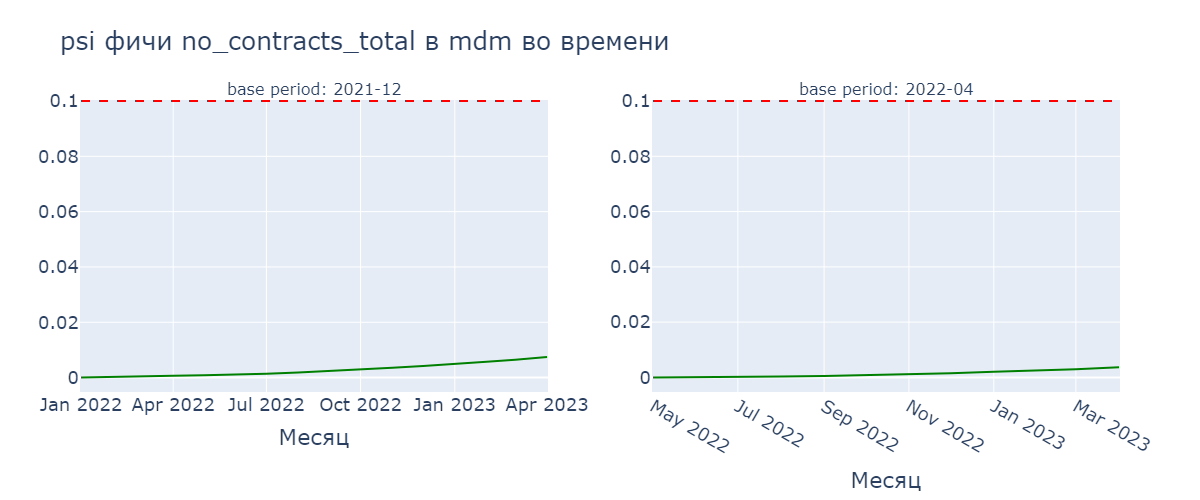

In [20]:
list_of_figs_mdm = []

for feature, featureProperty in allFeaturesProperties.items():
    feature_name = featureProperty['short_name']

    title = 'psi фичи {} в mdm во времени'.format(feature)
    base_period = psi_mdm['base_period'].unique()
    mask = (psi_mdm['feature']==feature)
    fig = psi_plot_2(psi_mdm[mask], feature, base_period, feature_name = feature_name, title = title)
    list_of_figs_mdm.append(fig)

combine_plotly_figs_to_html(list_of_figs_mdm, pre+'data/html/psi_mdm.html')
list_of_figs_mdm[0].show('png' if need_svg else '')

In [21]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()